In [1]:
import pandas as pd
import numpy as np
import spacy
import gensim
import operator
import re
import string

In [2]:
df_schemes = pd.read_csv('../df.csv', encoding='mac_roman')
df_schemes.tail()

,Scheme,Description,Agency,FSC,Image,Link,Who's it for,What it gives,Scheme Type,search_booster(WL),Unnamed: 10
358,THK Home Care Services,THK Home Care Services provide holistic and pe...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-h...,"Elderly,Low income,PWD","Healthcare,Caregivers,Emotional care,Low income","Elderly,PWD,Healthcare,Caregiver,Low income","Disabled elderly, need home treatment, weak ca...",Kenneth
359,THK Seniors Services @ Taman Jurong,Encourage seniors to remain integrated in soci...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-s...,Elderly,"Activities for elderly, social support for eld...",Elderly,"Lonely senior, alone, no friends, poor, living...",Kenneth
360,THK Home Help Services (HHS),THK Home Help Services (HHS) were created to a...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-h...,"Elderly,Low income,PWD","Social support for elderly,Caregivers,Low inco...","Elderly,Low income,PWD,Food,Transport","Disabled elderly, weak cannot walk, vulnerable...",Kenneth
361,THK Cluster Support,a. To provide social support through case mana...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-c...,"Elderly,Low income,PWD","Activities for elderly, social support for eld...","Elderly,PWD,Healthcare,Caregiver,Referral,Low ...","Lonely senior, alone, no friends, poor, living...",Kenneth
362,THK CREST,Objectives \nTo raise awareness and educate re...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-c...,"Elderly,Caregiver,Mental health","Social support,Counselling","Elderly,Mental health,Caregiver","Lonely elderly, stressed old people, stressed ...",Kenneth


In [3]:
#Create tag list
#df_schemes['Tags'] = [x for x in df_schemes[df_schemes.columns[5:8]].values]
#df_schemes['Tags'] = df_schemes['Tags'].apply(lambda x: [i for i in x if str(i) != "nan"])
#df_schemes

#Create concatenated column
df_schemes['Combined'] = df_schemes[['Description','search_booster(WL)']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [4]:
df_schemes

,Scheme,Description,Agency,FSC,Image,Link,Who's it for,What it gives,Scheme Type,search_booster(WL),Unnamed: 10,Combined
0,Various services,Information relating to social service and ref...,@27 Family Service Centre,Yes,https://chidnast.sirv.com/SchemesSG/27fsc.jpg,https://www.27fsc.org.sg/,Families,"Counselling,Casework","Low Income,Family","social service, individuals, families, casewor...",NaN,Information relating to social service and ref...
1,Financial Assistance,Cancer treatment can place a heavy financial b...,365 Cancer Prevention Society (365CPS),NaN,https://chidnast.sirv.com/SchemesSG/365cps.jpg,https://365cps.org.sg/portfolio/financial-supp...,Cancer patients,Financial assistance for cancer treatment,"Low Income,Healthcare","See doctor, cancer, oncology",NaN,Cancer treatment can place a heavy financial b...
2,Food Assistance,A self setup group which distributes meal box ...,A Packet of Rice,NaN,https://chidnast.sirv.com/SchemesSG/apacketofr...,https://www.facebook.com/APacketOfRice/,"Low income,Need food support",Food,"Low Income,Food","Needs help to get food, meal, hungry, have not...",NaN,A self setup group which distributes meal box ...
3,Rehabilitation Centre and Respite Centre,"Provides Occupational Therapy, Physiotherapy a...",Abilities Beyond Limitations and Expectations ...,NaN,https://chidnast.sirv.com/SchemesSG/able.jpg,https://www.able-sg.org/,"PWD,Elderly,Caregivers","Occupational therapy,Physiotherapy,Educational...","PWD,Family,Transport,Healthcare,Mental Health","rehabilitation, occupational therapy, physioth...",NaN,"Provides Occupational Therapy, Physiotherapy a..."
4,Various Services,We prepare educational programs (IT Training) ...,Acronis Foundation,NaN,https://chidnast.sirv.com/SchemesSG/acronis.jpg,https://acronis.org/rehabilitation-of-inmates/,Ex-offenders,"Vocational training,Employment assistance","Ex-offender,Employment","ex-convict need job, ex-convict skills trainin...",phyllis,We prepare educational programs (IT Training) ...
...,...,...,...,...,...,...,...,...,...,...,...,...
358,THK Home Care Services,THK Home Care Services provide holistic and pe...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-h...,"Elderly,Low income,PWD","Healthcare,Caregivers,Emotional care,Low income","Elderly,PWD,Healthcare,Caregiver,Low income","Disabled elderly, need home treatment, weak ca...",Kenneth,THK Home Care Services provide holistic and pe...
359,THK Seniors Services @ Taman Jurong,Encourage seniors to remain integrated in soci...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-s...,Elderly,"Activities for elderly, social support for eld...",Elderly,"Lonely senior, alone, no friends, poor, living...",Kenneth,Encourage seniors to remain integrated in soci...
360,THK Home Help Services (HHS),THK Home Help Services (HHS) were created to a...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-h...,"Elderly,Low income,PWD","Social support for elderly,Caregivers,Low inco...","Elderly,Low income,PWD,Food,Transport","Disabled elderly, weak cannot walk, vulnerable...",Kenneth,THK Home Help Services (HHS) were created to a...
361,THK Cluster Support,a. To provide social support through case mana...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-c...,"Elderly,Low income,PWD","Activities for elderly, social support for eld...","Elderly,PWD,Healthcare,Caregiver,Referral,Low ...","Lonely senior, alone, no friends, poor, living...",Kenneth,a. To provide social support through case mana...


In [5]:
from spacy.lang.en.stop_words import STOP_WORDS
import string

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

to_delete = ["alone","themselves"]
for elem in to_delete:
    stop_words.discard(elem)
stop_words.add("client")

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctuations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

In [6]:
%time df_schemes['Tags_tokenized'] = df_schemes['Combined'].map(lambda x: spacy_tokenizer(x))

df_schemes

Wall time: 7.05 s


,Scheme,Description,Agency,FSC,Image,Link,Who's it for,What it gives,Scheme Type,search_booster(WL),Unnamed: 10,Combined,Tags_tokenized
0,Various services,Information relating to social service and ref...,@27 Family Service Centre,Yes,https://chidnast.sirv.com/SchemesSG/27fsc.jpg,https://www.27fsc.org.sg/,Families,"Counselling,Casework","Low Income,Family","social service, individuals, families, casewor...",NaN,Information relating to social service and ref...,"[information, relate, social, service, referra..."
1,Financial Assistance,Cancer treatment can place a heavy financial b...,365 Cancer Prevention Society (365CPS),NaN,https://chidnast.sirv.com/SchemesSG/365cps.jpg,https://365cps.org.sg/portfolio/financial-supp...,Cancer patients,Financial assistance for cancer treatment,"Low Income,Healthcare","See doctor, cancer, oncology",NaN,Cancer treatment can place a heavy financial b...,"[cancer, treatment, place, heavy, financial, b..."
2,Food Assistance,A self setup group which distributes meal box ...,A Packet of Rice,NaN,https://chidnast.sirv.com/SchemesSG/apacketofr...,https://www.facebook.com/APacketOfRice/,"Low income,Need food support",Food,"Low Income,Food","Needs help to get food, meal, hungry, have not...",NaN,A self setup group which distributes meal box ...,"[self, setup, group, distribute, meal, box, lo..."
3,Rehabilitation Centre and Respite Centre,"Provides Occupational Therapy, Physiotherapy a...",Abilities Beyond Limitations and Expectations ...,NaN,https://chidnast.sirv.com/SchemesSG/able.jpg,https://www.able-sg.org/,"PWD,Elderly,Caregivers","Occupational therapy,Physiotherapy,Educational...","PWD,Family,Transport,Healthcare,Mental Health","rehabilitation, occupational therapy, physioth...",NaN,"Provides Occupational Therapy, Physiotherapy a...","[provide, occupational, therapy, physiotherapy..."
4,Various Services,We prepare educational programs (IT Training) ...,Acronis Foundation,NaN,https://chidnast.sirv.com/SchemesSG/acronis.jpg,https://acronis.org/rehabilitation-of-inmates/,Ex-offenders,"Vocational training,Employment assistance","Ex-offender,Employment","ex-convict need job, ex-convict skills trainin...",phyllis,We prepare educational programs (IT Training) ...,"[prepare, educational, program, training, offe..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,THK Home Care Services,THK Home Care Services provide holistic and pe...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-h...,"Elderly,Low income,PWD","Healthcare,Caregivers,Emotional care,Low income","Elderly,PWD,Healthcare,Caregiver,Low income","Disabled elderly, need home treatment, weak ca...",Kenneth,THK Home Care Services provide holistic and pe...,"[thk, home, care, services, provide, holistic,..."
359,THK Seniors Services @ Taman Jurong,Encourage seniors to remain integrated in soci...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-s...,Elderly,"Activities for elderly, social support for eld...",Elderly,"Lonely senior, alone, no friends, poor, living...",Kenneth,Encourage seniors to remain integrated in soci...,"[encourage, senior, remain, integrated, societ..."
360,THK Home Help Services (HHS),THK Home Help Services (HHS) were created to a...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-h...,"Elderly,Low income,PWD","Social support for elderly,Caregivers,Low inco...","Elderly,Low income,PWD,Food,Transport","Disabled elderly, weak cannot walk, vulnerable...",Kenneth,THK Home Help Services (HHS) were created to a...,"[thk, home, help, services, hhs, create, assis..."
361,THK Cluster Support,a. To provide social support through case mana...,Thye Hua Kwan Moral Charities (THKMC),NaN,https://chidnast.sirv.com/SchemesSG/thk360.jpg,https://www.thkmc.org.sg/services_detail/thk-c.

In [7]:
Description_to_match = df_schemes['Tags_tokenized']
Description_to_match[0:5]

0    [information, relate, social, service, referra...
1    [cancer, treatment, place, heavy, financial, b...
2    [self, setup, group, distribute, meal, box, lo...
3    [provide, occupational, therapy, physiotherapy...
4    [prepare, educational, program, training, offe...
Name: Tags_tokenized, dtype: object

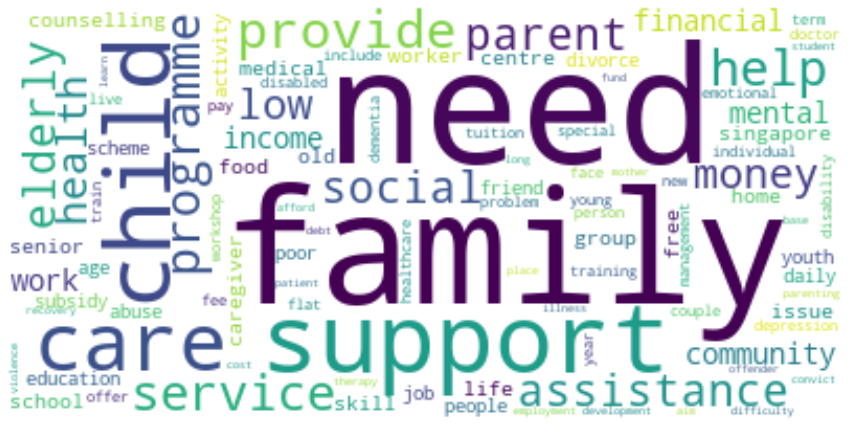

In [8]:
#Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(Description_to_match)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
#build word dictionary

from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(Description_to_match)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)
dictionary.save('dictionary')

Wall time: 32.9 ms


In [10]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['appropriate', 0], ['casework', 1], ['counsel', 2], ['counselling', 3], ['family', 4], ['groupwork', 5], ['individual', 6], ['information', 7], ['referral', 8], ['relate', 9], ['service', 10], ['social', 11], ['therapeutic', 12], ['365cps', 13], ['aid', 14], ['burden', 15], ['cancer', 16], ['daily', 17], ['doctor', 18], ['educate', 19], ['emotional', 20], ['financial', 21], ['find', 22], ['health', 23], ['heavy', 24], ['help', 25], ['immunity', 26], ['improve', 27], ['income', 28], ['low', 29], ['meet', 30], ['member', 31], ['need', 32], ['oncology', 33], ['oneís', 34], ['patient', 35], ['place', 36], ['provide', 37], ['support', 38], ['treatment', 39], ['box', 40], ['bukit', 41], ['child', 42], ['citizen', 43], ['day', 44], ['distribute', 45], ['eat', 46], ['flat', 47], ['food', 48], ['group', 49], ['hungry', 50]]]


In [11]:
#Bag of words
corpus = [dictionary.doc2bow(desc) for desc in Description_to_match]
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]
print(word_frequencies)

[[('appropriate', 1), ('casework', 2), ('counsel', 1), ('counselling', 1), ('family', 1), ('groupwork', 1), ('individual', 1), ('information', 1), ('referral', 1), ('relate', 1), ('service', 3), ('social', 2), ('therapeutic', 1)], [('family', 1), ('365cps', 1), ('aid', 1), ('burden', 1), ('cancer', 3), ('daily', 1), ('doctor', 1), ('educate', 1), ('emotional', 1), ('financial', 1), ('find', 1), ('health', 1), ('heavy', 1), ('help', 1), ('immunity', 1), ('improve', 1), ('income', 1), ('low', 1), ('meet', 1), ('member', 1), ('need', 1), ('oncology', 1), ('oneís', 1), ('patient', 2), ('place', 2), ('provide', 1), ('support', 1), ('treatment', 1)], [('help', 1), ('income', 1), ('low', 1), ('need', 1), ('box', 1), ('bukit', 1), ('child', 1), ('citizen', 1), ('day', 1), ('distribute', 1), ('eat', 1), ('flat', 1), ('food', 2), ('group', 1), ('hungry', 1), ('meal', 2), ('merah', 1), ('near', 1), ('needs', 1), ('needy', 1), ('operate', 1), ('region', 1), ('rented', 1), ('reside', 1), ('resident

In [12]:
#TF IDF and LSI
%time schemes_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
schemes_tfidf_model.save("tfidf.model")
%time schemes_lsi_model = gensim.models.LsiModel(schemes_tfidf_model[corpus], id2word=dictionary, num_topics=300)
schemes_lsi_model.save("lsi.model")

Wall time: 13 ms
Wall time: 778 ms


In [13]:
%time gensim.corpora.MmCorpus.serialize('schemes_tfidf_model_mm', schemes_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('schemes_lsi_model_mm',schemes_lsi_model[schemes_tfidf_model[corpus]])

Wall time: 99.6 ms
Wall time: 481 ms


In [14]:
#Load indexed corpus
schemes_tfidf_corpus = gensim.corpora.MmCorpus('schemes_tfidf_model_mm')
schemes_lsi_corpus = gensim.corpora.MmCorpus('schemes_lsi_model_mm')

print(schemes_tfidf_corpus)
print(schemes_lsi_corpus)

MmCorpus(363 documents, 2631 features, 11748 non-zero entries)
MmCorpus(363 documents, 300 features, 108900 non-zero entries)


In [15]:
from gensim.similarities import MatrixSimilarity

%time schemes_index = MatrixSimilarity(schemes_lsi_corpus, num_features = schemes_lsi_corpus.num_terms)

Wall time: 193 ms


In [16]:
#Search similarity

from operator import itemgetter

def search_similar_schemes(search_term):
    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = schemes_tfidf_model[query_bow]
    query_lsi = schemes_lsi_model[query_tfidf]

    schemes_index.num_best = 50

    schemes_list = schemes_index[query_lsi]

    schemes_list.sort(key=itemgetter(1), reverse=True)
    schemes_names = []

    for j, scheme in enumerate(schemes_list):

        schemes_names.append (
            {
                'Relevance': round((scheme[1] * 100),2),
                'Scheme Title': df_schemes['Scheme'][scheme[0]],
                'Description': df_schemes['Description'][scheme[0]]
            }

        )
        if j == (schemes_index.num_best-1):
            break

    return pd.DataFrame(schemes_names, columns=['Relevance','Scheme Title','Description'])

In [17]:
search_similar_schemes('pregnant teen')

,Relevance,Scheme Title,Description
0,78.52,HCSA Dayspring SPIN,SPIN empowers single parents to make informed ...
1,61.58,Pregnancy Crisis and Support,"For emotional support, guidance, help and refe..."
2,50.14,Babes - A Helping Hand for Pregnant Teens,Staff will discuss the various options availab...
3,32.02,Safe Place,"Safe Place provides timely, non-judgmental and..."
4,30.65,Information,"Information on various issues, including contr..."
5,7.08,Casework and Counselling,"PPIS serves clients who face marital issues, f..."
6,2.19,Project LADDER,Project LADDER reaches out to families of inma...
7,2.11,SAFE Programme (Stop Abuse in Families),TRANS SAFE Centre is a Family Violence Special...
8,2.09,HIV+ Pregnant Mothers' Fund,Assistance for HIV positive mothers who cannot...
9,1.74,Food Care Programme,Food Care Programme provides food and daily ne...


In [18]:
import flask
print(flask.__version__)

1.1.2


In [19]:
import pickle
print(pickle.format_version)

4.0
